In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout, Dense
import random

In [2]:

SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

In [4]:
df = pd.read_csv(r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\15_Revised_Wenzhao\Final_Data_revised.csv')
df['tmean'] = (df['tmax'] + df['tmin']) / 2
df['RH'] = df['hum']
df['tw'] = (
    df['tmean'] * np.arctan(0.151977 * np.sqrt(df['RH'] + 8.313659)) +
    np.arctan(df['tmean'] + df['RH']) -
    np.arctan(df['RH'] - 1.676331) +
    0.00391838 * df['RH']**(3/2) * np.arctan(0.023101 * df['RH']) -
    4.686035
)
df['phase'] = np.where(df['tw'] <= 0, 0, 1)
df = df.drop(columns=['tmean', 'RH','tw'])

In [5]:
# !pip install bayesian-optimization

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Best hyperparameters found:
  LSTM1 Units:   128
  LSTM2 Units:   32
  Dropout Rate:  0.2
  Learning Rate: 0.01
  Batch Size:    16
Epoch 1/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - loss: 0.0251 - val_loss: 0.0046
Epoch 2/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 3/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 4/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 5/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 6/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 7/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/100
289/289 ━━━━━

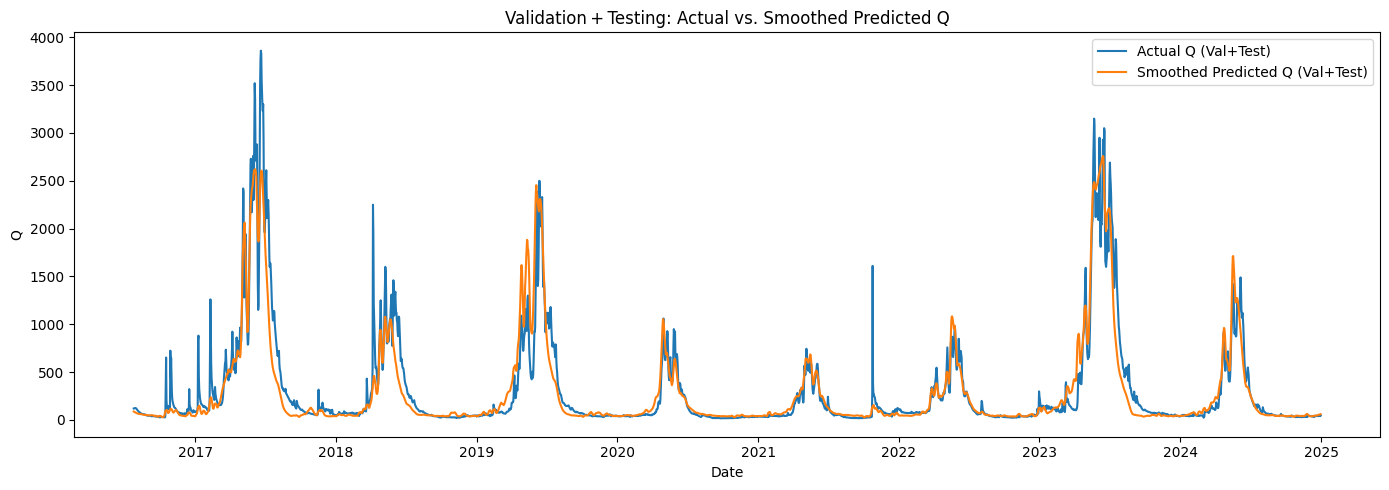

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Load the dataset
df = pd.read_csv(r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\15_Revised_Wenzhao\Final_Data_revised.csv')
# T_base = 0
# df['Melt_Index'] = np.maximum(0, df['tmax'] - T_base) * df['shortwave_radiation']
df['tmean'] = (df['tmax'] + df['tmin']) / 2
df['RH'] = df['hum']
df['tw'] = (
    df['tmean'] * np.arctan(0.151977 * np.sqrt(df['RH'] + 8.313659)) +
    np.arctan(df['tmean'] + df['RH']) -
    np.arctan(df['RH'] - 1.676331) +
    0.00391838 * df['RH']**(3/2) * np.arctan(0.023101 * df['RH']) -
    4.686035
)
df['phase'] = np.where(df['tw'] <= 0, 0, 1)
df = df.drop(columns=['tmean', 'RH', 'tw'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Features & target
X = df.drop(columns=['date', 'Discharge'])
y = df['Discharge'].values.reshape(-1, 1)

# Scale to [0,1]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Sequence builder
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

lookback = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)


# ─── 60/30/10 Split ──────────────────────────────────────────────────
n = len(X_seq)
cal_end = int(0.6 * n)
val_end = int(0.9 * n)

X_cal, y_cal = X_seq[:cal_end], y_seq[:cal_end]
X_val, y_val = X_seq[cal_end:val_end], y_seq[cal_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

# ─── Metrics ─────────────────────────────────────────────────────────
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def kge(y_true, y_pred, eps=1e-10):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    std_true, std_pred = np.std(y_true), np.std(y_pred)
    if std_true < eps or std_pred < eps:
        return np.nan
    r = np.corrcoef(y_true, y_pred)[0,1]
    alpha = std_pred / std_true
    beta = np.mean(y_pred) / (np.mean(y_true) + eps)
    return 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)

def pbias(y_true, y_pred):
    return 100 * (np.sum(y_pred - y_true) / np.sum(y_true))
# ─── Discrete Search Space ─────────────────────────────────────────
lstm1_options   = [128]
lstm2_options   = [32]
dropout_options = [0.2]
lr_options      = [1e-2]
batch_options   = [16]

# ─── Objective Function ─────────────────────────────────────────────
def build_and_eval(l1_idx, l2_idx, d_idx, lr_idx, b_idx):
    l1 = lstm1_options[int(round(l1_idx))]
    l2 = lstm2_options[int(round(l2_idx))]
    d  = dropout_options[int(round(d_idx))]
    lr = lr_options[int(round(lr_idx))]
    bs = batch_options[int(round(b_idx))]

    inp = Input(shape=(lookback, X.shape[1]))
    x   = LSTM(l1, return_sequences=True, recurrent_dropout=d)(inp)
    x   = LSTM(l2, return_sequences=False, recurrent_dropout=d)(x)
    out = Dense(1)(x)

    m = Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    m.fit(X_cal, y_cal, epochs=100, batch_size=bs,
          validation_data=(X_val, y_val), verbose=0)

    pred   = scaler_y.inverse_transform(m.predict(X_val))
    actual = scaler_y.inverse_transform(y_val)
    return nse(actual, pred)

pbounds = {
    'l1_idx': (0, len(lstm1_options)-1),
    'l2_idx': (0, len(lstm2_options)-1),
    'd_idx':  (0, len(dropout_options)-1),
    'lr_idx': (0, len(lr_options)-1),
    'b_idx':  (0, len(batch_options)-1)
}

# ─── Run Bayesian Optimization ──────────────────────────────────────
optimizer = BayesianOptimization(
    f=build_and_eval,
    pbounds=pbounds,
    random_state=SEED,
    verbose=0
)
optimizer.maximize(init_points=5, n_iter=15)

# ─── Extract best hyperparameters ───────────────────────────────────
best = optimizer.max['params']
best_lstm1   = lstm1_options[int(round(best['l1_idx']))]
best_lstm2   = lstm2_options[int(round(best['l2_idx']))]
best_dropout = dropout_options[int(round(best['d_idx']))]
best_lr      = lr_options[int(round(best['lr_idx']))]
best_batch   = batch_options[int(round(best['b_idx']))]

# ─── Print best combination ─────────────────────────────────────────
print("\nBest hyperparameters found:")
print(f"  LSTM1 Units:   {best_lstm1}")
print(f"  LSTM2 Units:   {best_lstm2}")
print(f"  Dropout Rate:  {best_dropout}")
print(f"  Learning Rate: {best_lr}")
print(f"  Batch Size:    {best_batch}")

# ─── Build & Train Final Model ───────────────────────────────────────
inputs = Input(shape=(lookback, X.shape[1]))
x = LSTM(best_lstm1, return_sequences=True, recurrent_dropout=best_dropout)(inputs)
x = LSTM(best_lstm2, return_sequences=False, recurrent_dropout=best_dropout)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
    loss='mse'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_cal, y_cal,
    epochs=100,
    batch_size=best_batch,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ─── Predict & Evaluate on 3 Sets ───────────────────────────────────
def eval_set(name, X_set, y_set):
    y_pred = scaler_y.inverse_transform(model.predict(X_set))
    y_true = scaler_y.inverse_transform(y_set)
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    r2    = r2_score(y_true, y_pred)
    n     = nse(y_true, y_pred)
    k     = kge(y_true, y_pred)
    pb    = pbias(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  MAE:   {mae:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  R²:    {r2:.4f}")
    print(f"  NSE:   {n:.4f}")
    print(f"  KGE:   {k:.4f}")
    print(f"  PBIAS: {pb:.2f}%")

eval_set("Calibration", X_cal, y_cal)
eval_set("Validation",  X_val, y_val)
eval_set("Testing",     X_test, y_test)

# ─── Plot Val+Test Actual vs. Smoothed Predicted ────────────────────
# build combined date index for val+test
dates = df['date'][lookback + cal_end : lookback + n]
pred = scaler_y.inverse_transform(model.predict(np.vstack((X_val, X_test))))
true = scaler_y.inverse_transform(np.vstack((y_val, y_test)))

series_pred = pd.Series(pred.flatten(), index=dates)
series_true = pd.Series(true.flatten(), index=dates)
series_smooth = series_pred.rolling(window=7, center=True, min_periods=1).mean()

plt.figure(figsize=(14,5))
plt.plot(dates, series_true,  label='Actual Q (Val+Test)')
plt.plot(dates, series_smooth, label='Smoothed Predicted Q (Val+Test)')
plt.xlabel('Date')
plt.ylabel('Q')
plt.title('Validation + Testing: Actual vs. Smoothed Predicted Q')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# ─── Export Predictions ────────────────────────────────────────────
# 1. Calibration set
cal_dates  = df['date'][lookback : lookback + cal_end]        # dates that line up with X_cal
cal_pred   = scaler_y.inverse_transform(model.predict(X_cal))
cal_true   = scaler_y.inverse_transform(y_cal)
df_cal = pd.DataFrame({
    'date': cal_dates,
    'set' : 'calibration',
    'Q_actual'   : cal_true.flatten(),
    'Q_predicted': cal_pred.flatten()
})

# 2. Validation set
val_dates  = df['date'][lookback + cal_end : lookback + val_end]
val_pred   = scaler_y.inverse_transform(model.predict(X_val))
val_true   = scaler_y.inverse_transform(y_val)
df_val = pd.DataFrame({
    'date': val_dates,
    'set' : 'validation',
    'Q_actual'   : val_true.flatten(),
    'Q_predicted': val_pred.flatten()
})

# 3. Testing set
test_dates = df['date'][lookback + val_end : lookback + n]
test_pred  = scaler_y.inverse_transform(model.predict(X_test))
test_true  = scaler_y.inverse_transform(y_test)
df_test = pd.DataFrame({
    'date': test_dates,
    'set' : 'testing',
    'Q_actual'   : test_true.flatten(),
    'Q_predicted': test_pred.flatten()
})

# 4. Combine and write to disk
df_out = pd.concat([df_cal, df_val, df_test], ignore_index=True)
csv_path = r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\15_Revised_Wenzhao\lstm_1d_Physic_Q_val_test.csv'
df_out.to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions saved to: C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\15_Revised_Wenzhao\lstm_1d_Physic_Q_val_test.csv
